In [1]:
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

import veccs.orderings
from batram.legmods import Data, SimpleTM

In [2]:
locs = pd.read_csv("locs.csv", header=None).values
obs = torch.as_tensor(pd.read_csv("stacked.csv", header=None).to_numpy(), dtype=torch.float32)
obs = obs.T

ord = np.lexsort((locs[:, 1], locs[:, 0]))
locs = locs[ord]
obs = obs[:, ord]


print(f"Locations array dimension: {locs.shape}")
print(f"Observations array dimension: {obs.shape}")

Locations array dimension: (4096, 2)
Observations array dimension: torch.Size([200, 4096])


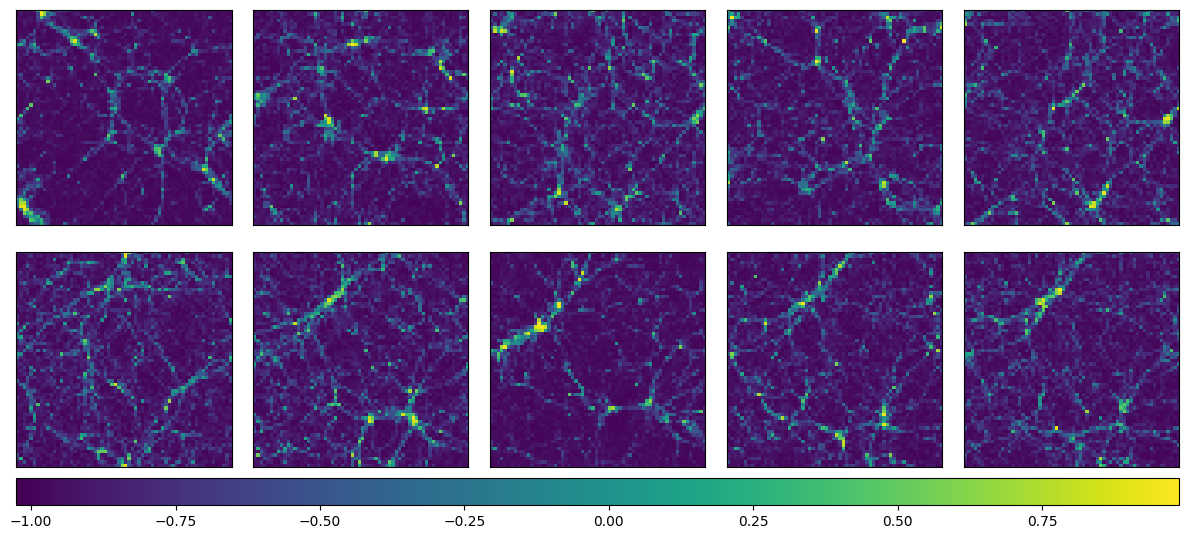

In [3]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(2, 5, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = obs[:10].min(), obs[:10].max()
for i in range(10):
    _ = ax[i // 5, i % 5]
    im = _.imshow(obs[i].reshape(64, 64), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

In [4]:
obs_mean = obs.mean(dim=0, keepdim=True)
obs_std = obs.std(dim=0, keepdim=True)

obs = (obs - obs_mean)/obs_std
obs_train = obs[0:150, ]
obs_test = obs[181:200, ]

order = veccs.orderings.maxmin_cpp(locs)

In [5]:
locs = locs[order, ...]
obs = obs[..., order]

largest_conditioning_set = 100

nn = veccs.orderings.find_nns_l2(locs, largest_conditioning_set)

In [6]:
locs = torch.as_tensor(locs, dtype=torch.float32)

data = Data.new(locs, obs, torch.as_tensor(nn))

In [9]:
tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4)

In [10]:
nsteps = 100
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(nsteps,0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=128)

Train Loss: 133308.007, Test Loss: 133307.984: 100%|██████████| 100/100 [20:58<00:00, 12.58s/it]


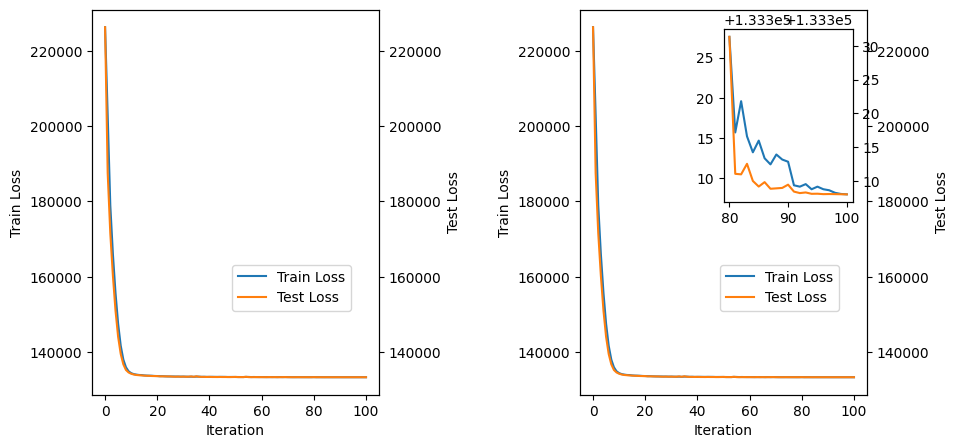

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"wspace": 0.7})
res.plot_loss(axs[0], use_inset=False)
res.plot_loss(axs[1], use_inset=True)
plt.show()

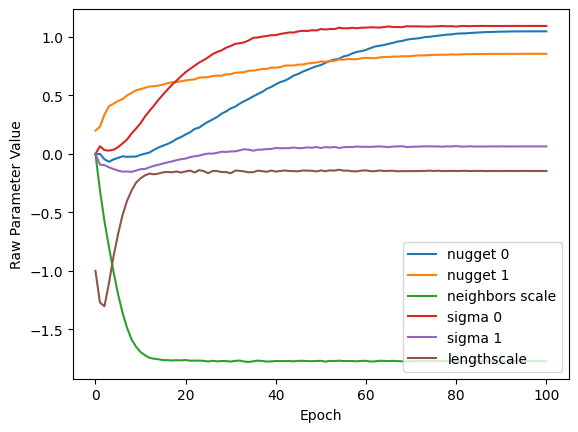

In [12]:
res.plot_params()
plt.show()

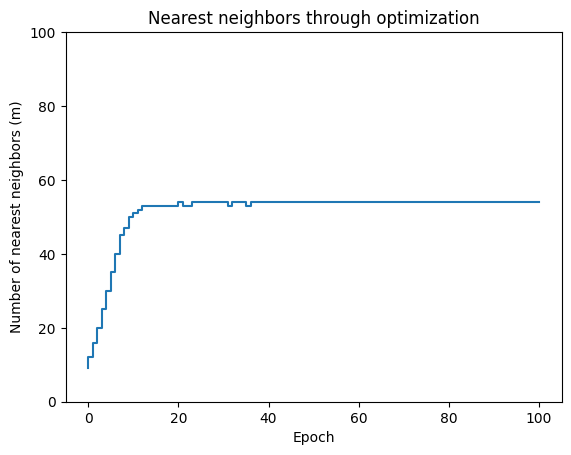

In [13]:
res.plot_neighbors()
plt.show()

In [14]:
new_sample = tm.cond_sample()[0, ...]
re_ordered_sample = torch.zeros_like(new_sample)
re_ordered_sample[..., order] = new_sample

In [15]:
obs_un = obs[0]*obs_std + obs_mean
simulated = re_ordered_sample*obs_std + obs_mean

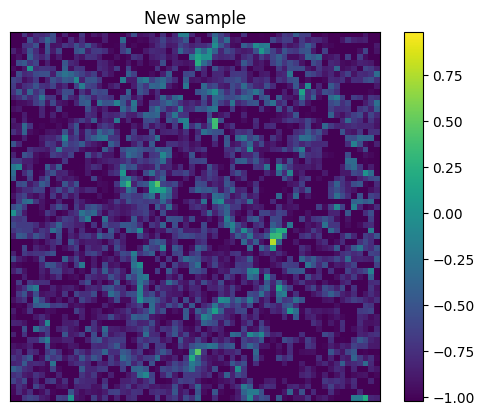

In [16]:
plt.imshow(simulated.reshape(64, 64), vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title("New sample")
plt.show()